# Tools


In [138]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from pandas import DataFrame
from sklearn import linear_model
from numpy import mean
from numpy import std
from numpy import array
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Data Loading

In [139]:
#Here we are reading the dataset and looking at the first five instances
chd_raw = pd.read_csv('chd-data.csv', sep=',')

# fetch dataset 
chd_raw.head()


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


Here we're changing the name of the columns "male" to "gender" (because why the fuck is it called male???) and "TenYearCHD" to "CHD" because it's more simple

In [140]:
chd_raw = chd_raw.rename(columns={'male': 'gender', 'TenYearCHD': 'CHD'})

In [141]:
chd_raw.head()

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,CHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


# Data observation

In [142]:
#Here we are describing the number of instances and columns
chd_raw.shape

(4240, 16)

In [143]:
chd_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  CHD              4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [144]:
chd_raw.describe()

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,CHD
count,4240.000000,4240.000000,4135.000000,4240.000000,4211.000000,4187.000000,4240.000000,4240.000000,4240.000000,4190.000000,4240.000000,4240.000000,4221.000000,4239.000000,3852.000000,4240.000000
mean,0.429245,49.580189,1.979444,0.494104,9.005937,0.029615,0.005896,0.310613,0.025708,236.699523,132.354599,82.897759,25.800801,75.878981,81.963655,0.151887
std,0.495027,8.572942,1.019791,0.500024,11.922462,0.169544,0.076569,0.462799,0.158280,44.591284,22.033300,11.910394,4.079840,12.025348,23.954335,0.358953
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


To see which variables that are categorical

In [145]:
chd_raw._get_numeric_data()

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,CHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0
4237,0,52,2.0,0,0.0,0.0,0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0
4238,1,40,3.0,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0


# Exploratory Data Analysis

Here we're checking how the dataset is distributed on our target variable

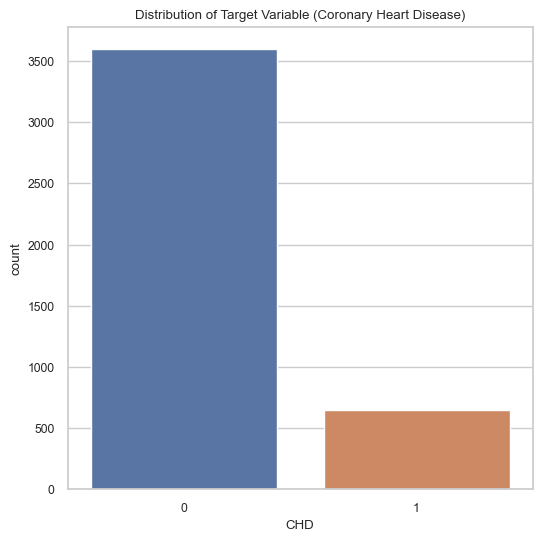

In [146]:
sns.set_style("whitegrid")

# Plot the target variable 'CHD'
plt.figure(figsize=(6, 6))
sns.countplot(x=chd_raw['CHD'])
plt.title('Distribution of Target Variable (Coronary Heart Disease)')
plt.show()

Interpretation of the result:

-
-
-
-
-


Here we're plotting the distribution of the categorical variables

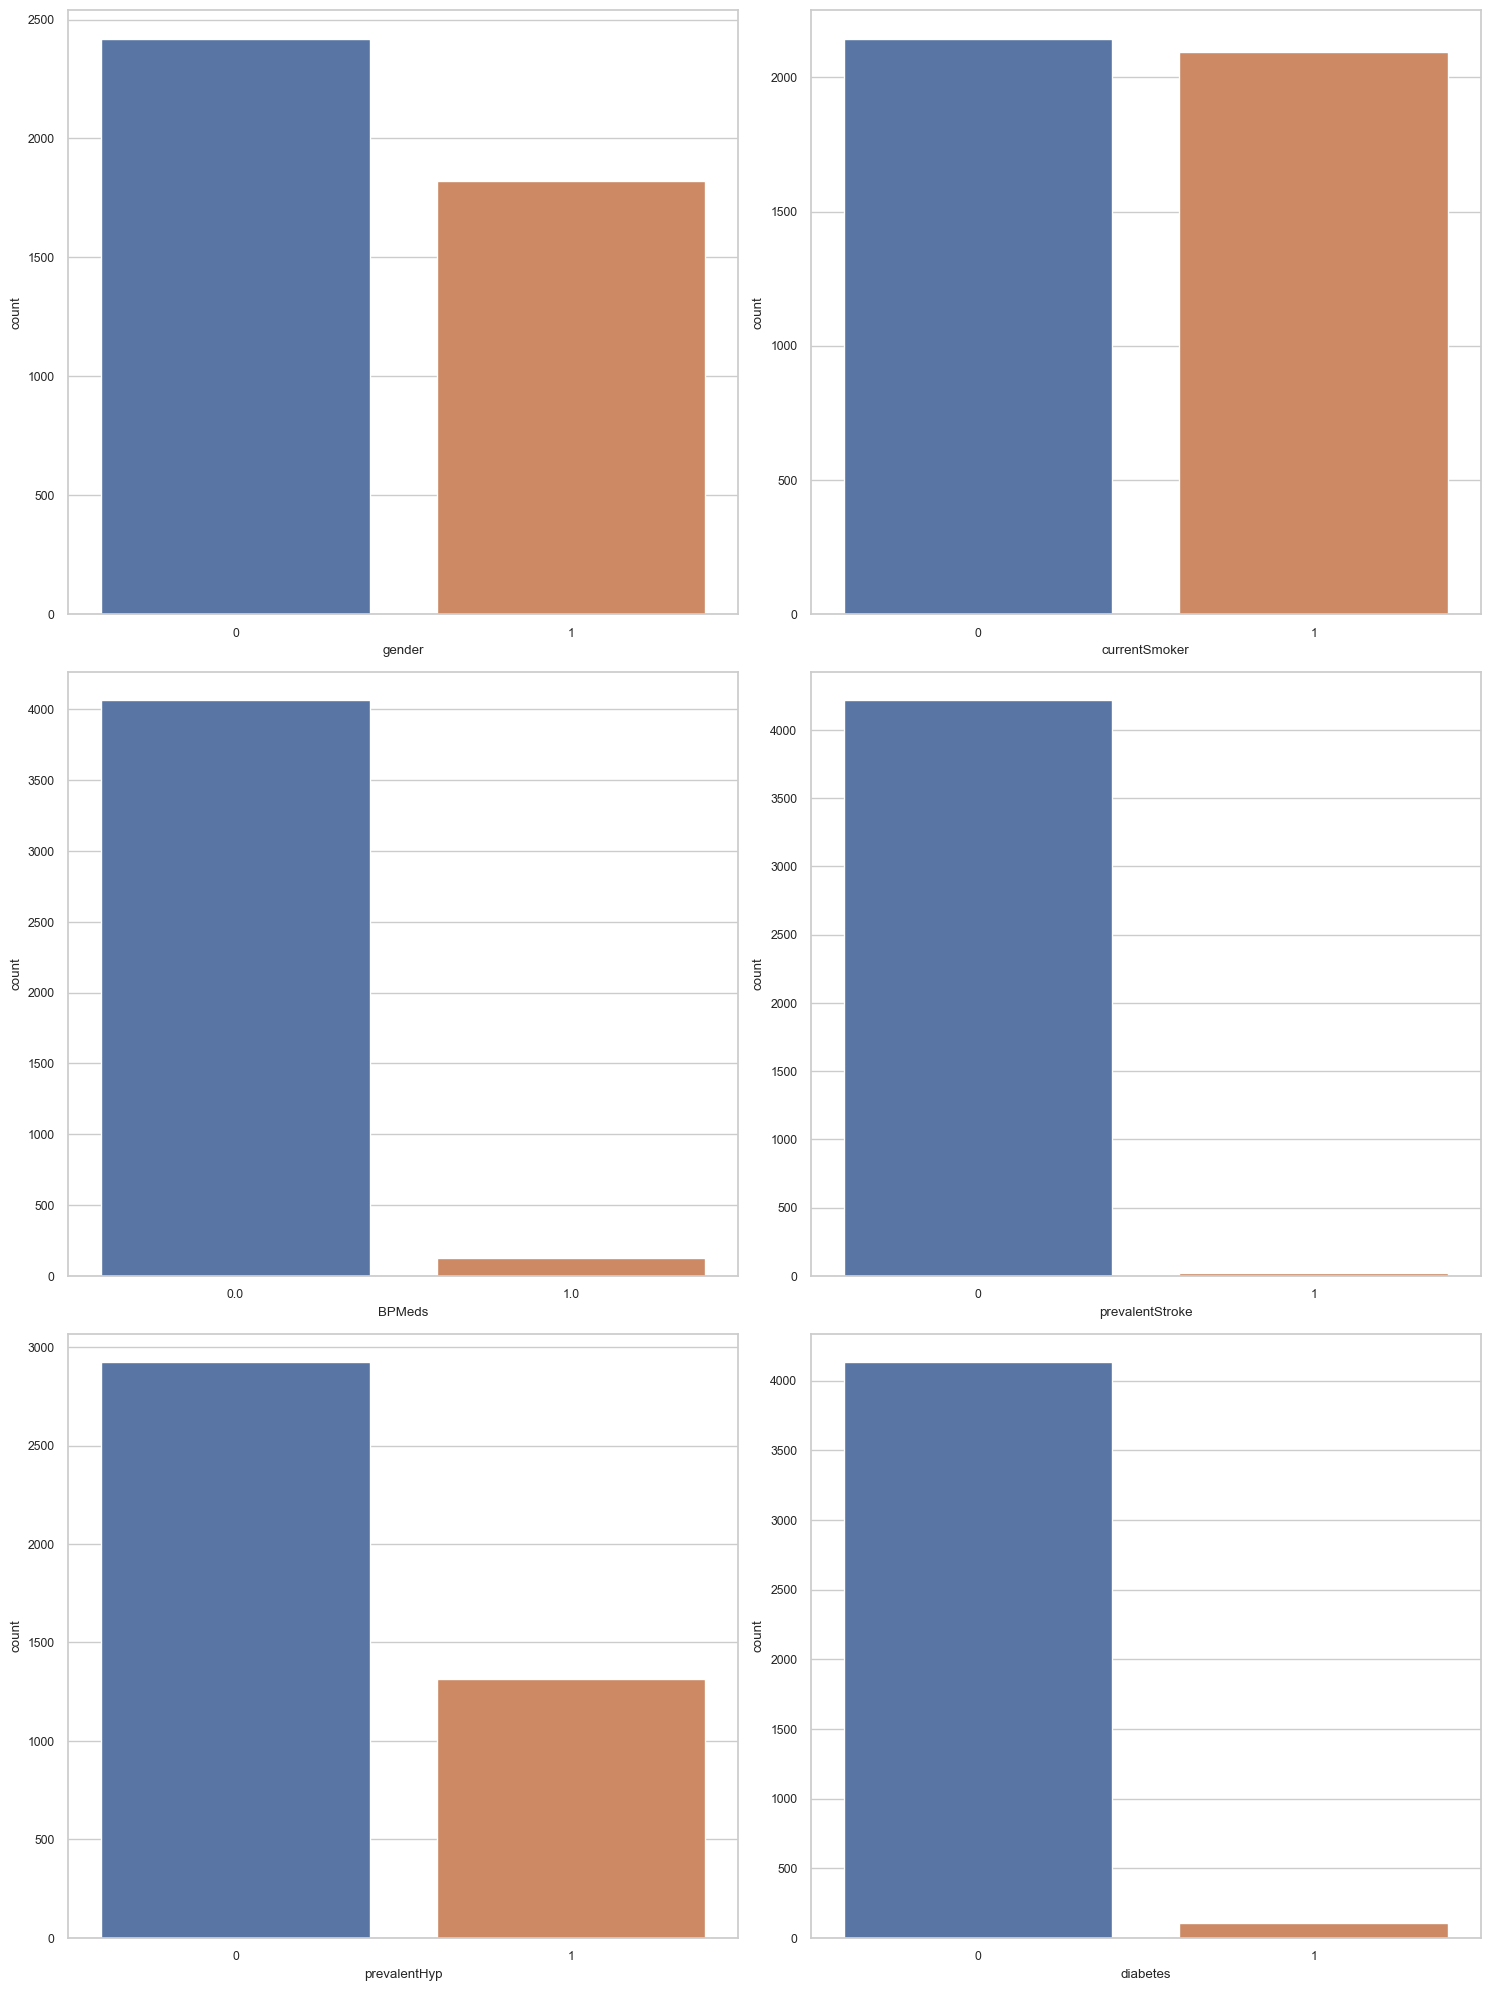

In [147]:
categorical_variables = ['gender', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

# Plotting the bar plots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))

for var, subplot in zip(categorical_variables, axs.flatten()):
    sns.countplot(x=var, data=chd_raw, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

plt.tight_layout()
plt.show()

Interpretation of the result:

-
-
-
-
-

Here we're checking the variables with categorical values against the target variable "CHD"

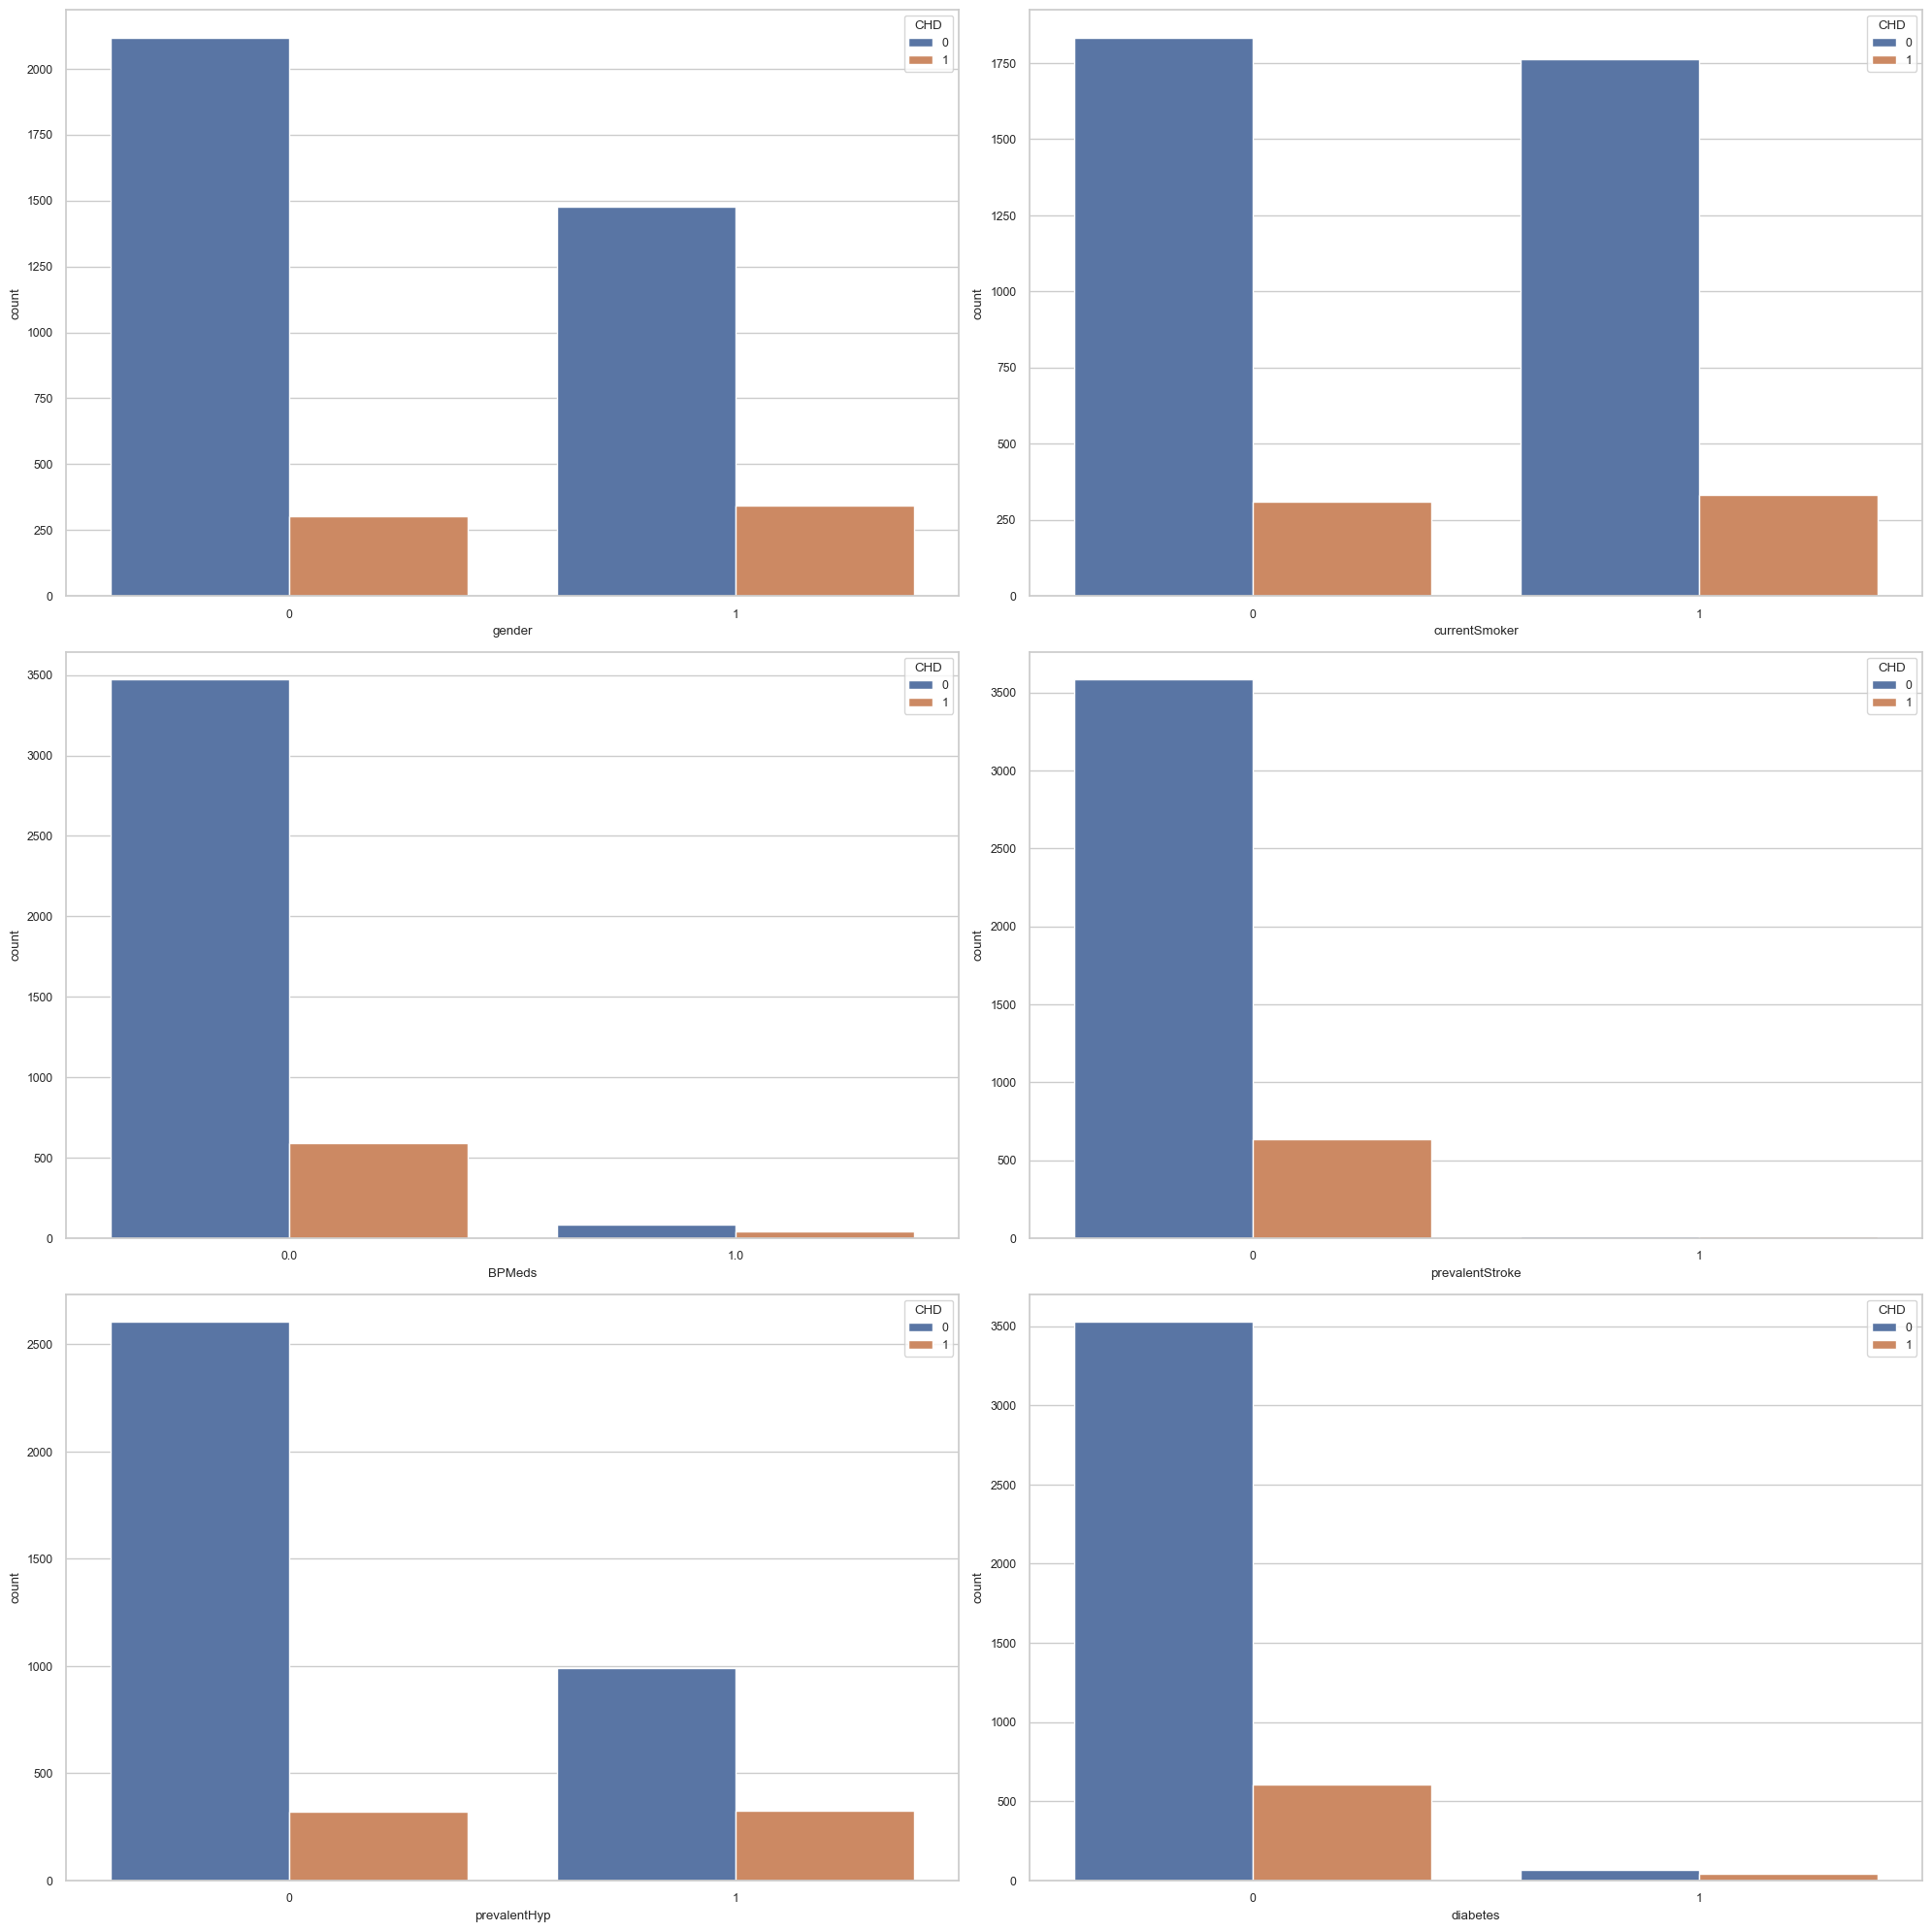

In [148]:
# Plot the categorical variables against the target variable 'CHD'
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

for var, subplot in zip(categorical_variables, axs.flatten()):
    sns.countplot(x=chd_raw[var], hue=chd_raw['CHD'], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

plt.tight_layout()
plt.show()

Interpretation of the result:

-
-
-
-
-

Here we're ...

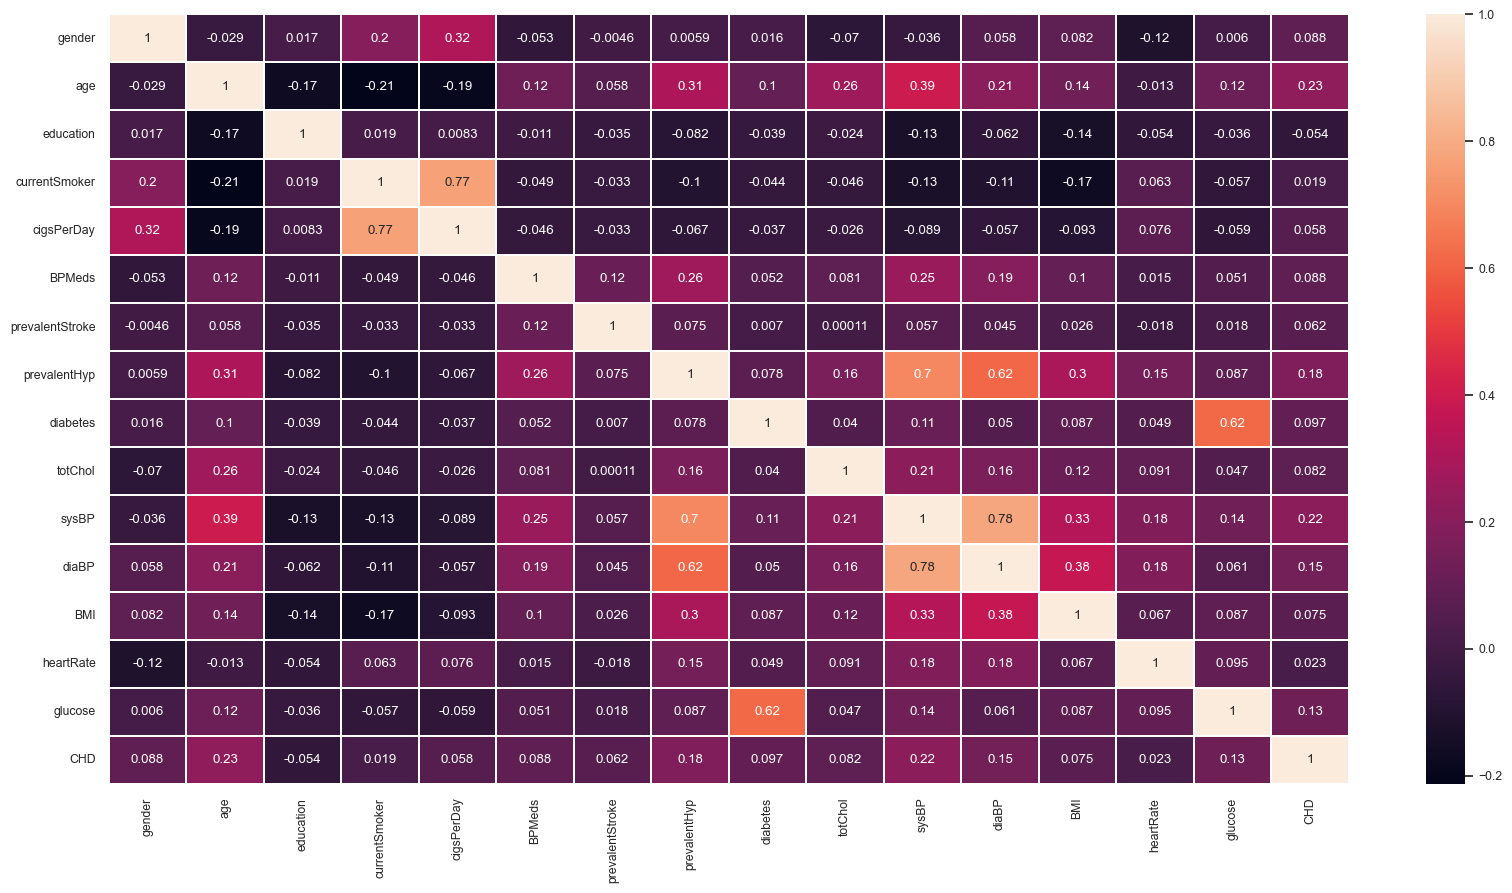

In [149]:
plt.figure(figsize=(20,10))
sns.heatmap(chd_raw.corr(),linewidths=0.1,annot=True)
# linewidths is white space between boxes and annot gives value
plt.show()

Interpretation of the result:

-
-
-
-
-

Here we're

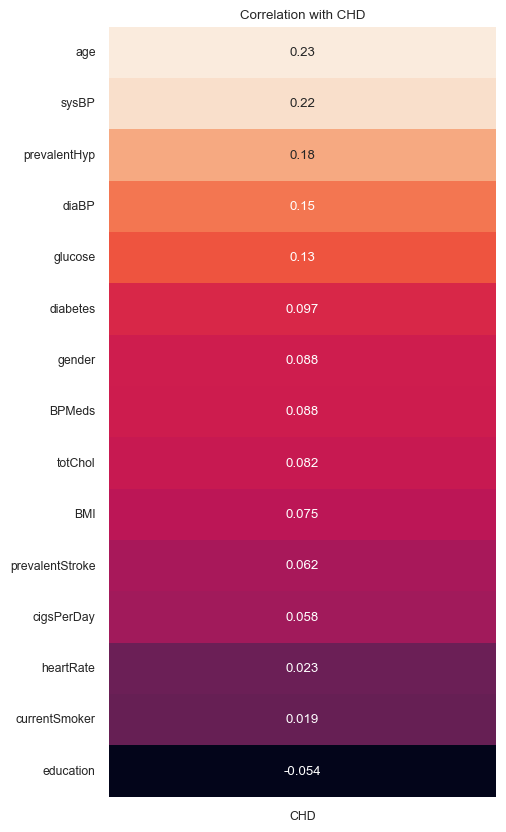

In [150]:
# Compute the correlation of each feature with the target variable 'stroke'
target_corr_one_hot = chd_raw.corr()['CHD'].drop('CHD')

# Sort correlation values in descending order - maybe change names
target_corr_sorted_one_hot = target_corr_one_hot.sort_values(ascending=False)

# Plot a heatmap of the correlations with the target column
plt.figure(figsize=(5, 10))
sns.set(font_scale=0.8)
sns.heatmap(target_corr_sorted_one_hot.to_frame(), annot=True, cbar=False)
plt.title('Correlation with CHD')
plt.show()

Interpretation of the result:

-
-
-
-
-

Here we're creating histograms to see the distribution of data

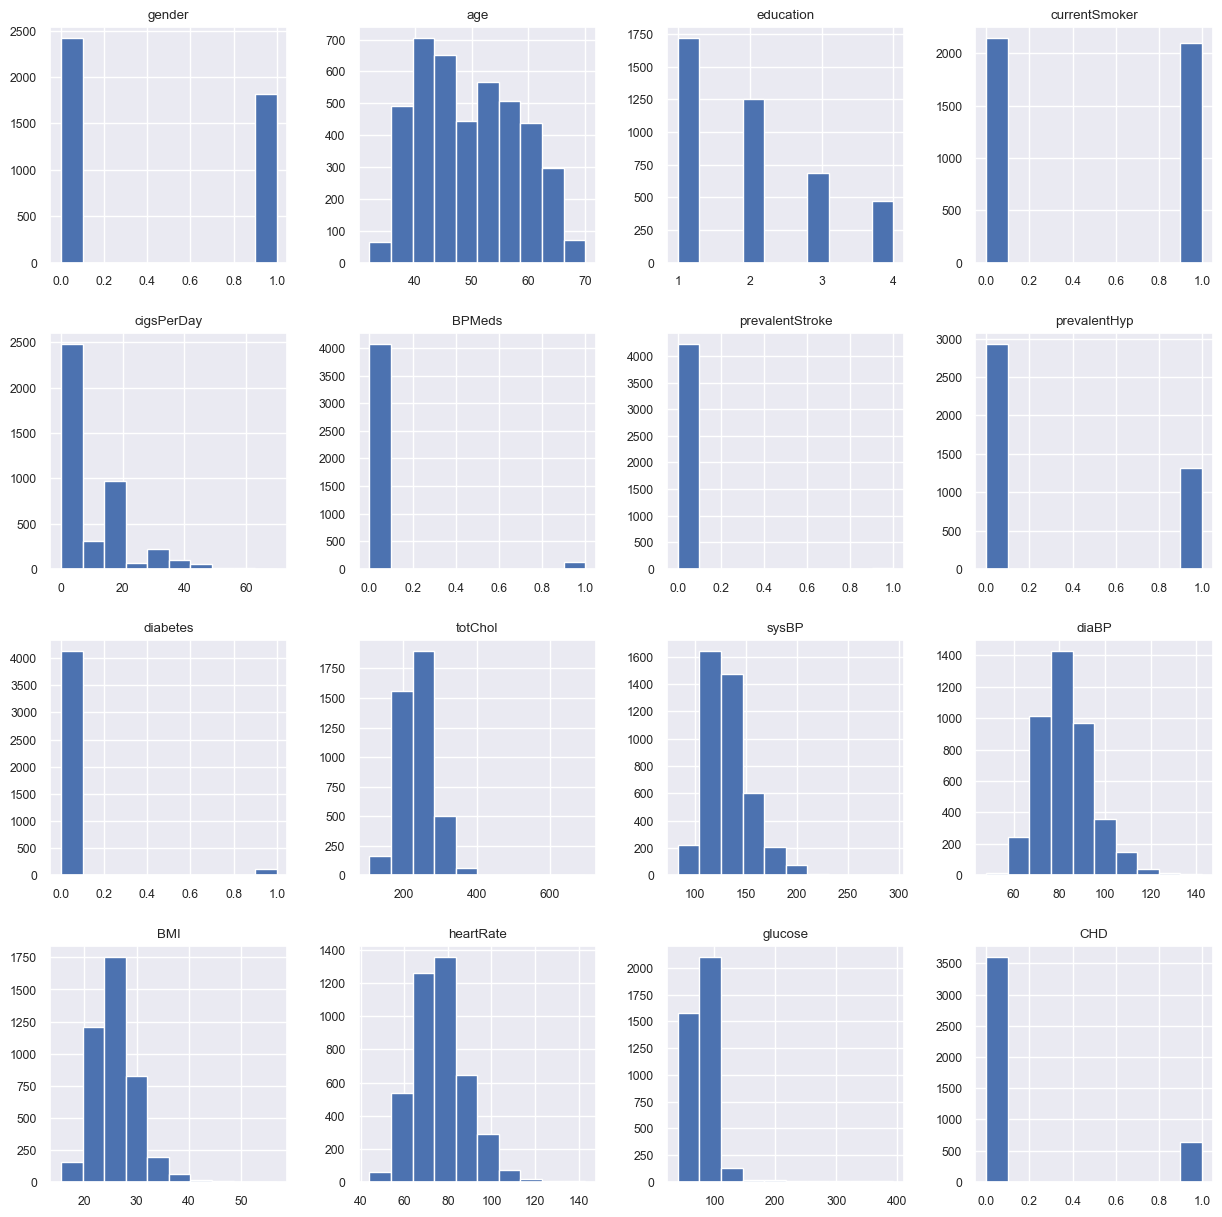

In [151]:
fig = plt.figure(figsize = (15,15))
chd_raw.hist(ax = fig.gca())
plt.show()

Interpretation of the result:

-
-


# Data Cleaning

Then we're checking how many duplicates there are in our dataset

In [152]:
chd_raw.duplicated().sum()

0

There's 0 so nothing to do with this

Finding how many columns that have missing values

In [153]:
missing_rows = chd_raw.isna().any(axis=1).sum()
missing_rows

582

In [154]:
null_counts = chd_raw.isna().sum()
null_counts

gender               0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
CHD                  0
dtype: int64

Finding how many columns that have more than 1 missing value in the same row

In [155]:
more_than_one_missing = chd_raw.isna().sum(axis=1)>1
more_than_one_missing_count = more_than_one_missing.sum()
more_than_one_missing_count

61

Result: we want to drop the rows that have more than 1 missing value, because 61 rows is very little compared to over 4000 instances

We didn't use dummy variables because there's no columns that has anything else than numeric values. 

Here we're dropping the rows that have more than 1 missing value

In [156]:
chd_df = chd_raw.dropna(thresh=len(chd_raw.columns)-1)

In [157]:
chd_df.isnull().sum()

gender               0
age                  0
education           93
currentSmoker        0
cigsPerDay          23
BPMeds              51
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              9
sysBP                0
diaBP                0
BMI                 13
heartRate            1
glucose            331
CHD                  0
dtype: int64

We're dropping the variable 'education' because there's no explanation of the numbers in the column

In [158]:
chd_df.drop(['education'], axis=1, inplace=True)

In [159]:
chd_df.isnull().sum()

gender               0
age                  0
currentSmoker        0
cigsPerDay          23
BPMeds              51
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              9
sysBP                0
diaBP                0
BMI                 13
heartRate            1
glucose            331
CHD                  0
dtype: int64

Now we're filling in the rest of the missing values - decision between mode, mean or median is based on the histograms above 

In [160]:
chd_df['cigsPerDay'].fillna(chd_df['cigsPerDay'].mode()[0], inplace=True)
chd_df['BPMeds'].fillna(chd_df['BPMeds'].mode()[0], inplace=True)
chd_df['totChol'].fillna(chd_df['totChol'].median(), inplace=True)  
chd_df['BMI'].fillna(chd_df['BMI'].median(), inplace=True)
chd_df['heartRate'].fillna(chd_df['heartRate'].mean(), inplace=True) 
chd_df['glucose'].fillna(chd_df['glucose'].median(), inplace=True)

In [161]:
chd_df.isnull().sum()

gender             0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
CHD                0
dtype: int64

# Feature Selection

Here we're checking which variables that have the strongest correlation with the target variable with SelectKBest and Chi2

In [162]:
X = chd_df.iloc[:,0:14]  
y = chd_df.iloc[:,-1]    

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(14,'Score'))

              Specs       Score
9             sysBP  719.013887
13          glucose  409.143289
1               age  332.288330
8           totChol  245.300295
3        cigsPerDay  244.923505
10            diaBP  149.101337
6      prevalentHyp   89.778295
7          diabetes   34.659164
4            BPMeds   28.228355
0            gender   19.193813
5   prevalentStroke   16.240656
11              BMI   15.681742
12        heartRate    4.212706
2     currentSmoker    0.959286


Based on the above results we have chosen to drop BMI, heartRate and currentSmoker as they have the least impact on target variable.

In [163]:
chd_df.drop(['BMI'], axis=1, inplace=True)
chd_df.drop(['heartRate'], axis=1, inplace=True)
chd_df.drop(['currentSmoker'], axis=1, inplace=True)

# Logistic Regression

In [164]:
X = chd_df.iloc[:,0:11]  
y = chd_df.iloc[:,-1] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state=42, stratify=y)
print(("Xtrain", X_train.shape, "y_train", 
      y_train.shape, "X_test", X_test.shape, "y_test", y_test.shape))

('Xtrain', (3134, 11), 'y_train', (3134,), 'X_test', (1045, 11), 'y_test', (1045,))


In [165]:
from collections import Counter
from imblearn.over_sampling import SMOTE

from collections import Counter
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_train, y_train) 

print('Without SMOTE')

print('Distribution of No CHD (0) and CHD (1) in target variable %s' % Counter(y))
print(f'''Shape of X: {X.shape}
Shape of y: {y.shape}''')
print('')

print('Re-sampled dataset - With SMOTE')
print('Distribution of No CHD (0) and CHD (1) in target variable %s ' % Counter(y_res))

print(f'''Shape of X: {X_res.shape}
Shape of y: {y_res.shape}''')


Without SMOTE
Distribution of No CHD (0) and CHD (1) in target variable Counter({0: 3547, 1: 632})
Shape of X: (4179, 11)
Shape of y: (4179,)

Re-sampled dataset - With SMOTE
Distribution of No CHD (0) and CHD (1) in target variable Counter({0: 2660, 1: 2660}) 
Shape of X: (5320, 11)
Shape of y: (5320,)


In [166]:
sum(y_res)/len(y_res)

0.5

WITHOUT SMOTE

In [167]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_y_pred = log_reg.predict(X_test)
print("Score on training set: {:.3f}".format(log_reg.score(X_train, y_train)))
print("Score on test set: {:.3f}".format(log_reg.score(X_test, y_test)))

Score on training set: 0.846
Score on test set: 0.839


WITH SMOTE

In [168]:
log_reg_sm = LogisticRegression(max_iter=1000)
log_reg_sm.fit(X_res, y_res)
log_reg_sm_y_pred = log_reg_sm.predict(X_test)
print("Accuracy on training set: {:.3f}".format(log_reg_sm.score(X_res, y_res)))
print("Accuracy on test set: {:.3f}".format(log_reg_sm.score(X_test, y_test)))

Accuracy on training set: 0.658
Accuracy on test set: 0.673


WITHOUT SMOTE

In [169]:
print(classification_report(y_test, log_reg_y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       887
           1       0.32      0.06      0.10       158

    accuracy                           0.84      1045
   macro avg       0.59      0.52      0.50      1045
weighted avg       0.77      0.84      0.79      1045



- Precision measures the accuracy of positive predictions. The model has a high precision (0.84) for predicting no CHD, meaning that when the model predicts that a patient will not have a CHD, it is correct 84% of the time. However, the precision is much lower for predicting stroke (0.5), meaning that when the model predicts a CHD, it is correct only 50% of the time

- Recall (also known as sensitivity or true positive rate) measures the fraction of positives that were correctly identified. The model has a recall of 1.0 for no CHD and 0.02 for CHD. This means that the model correctly identifies 100% of the patients who will not have a CHD and 0.2% of the patients who will have a CHD. The lower recall for CHD indicates that the model is missing a large number of patients who will have a CHD.

- The F1 score is a weighted average of precision and recall. The F1 scores for no CHD and CHD are 0.91 and 0.03, respectively. The low F1 score for CHD indicates that the model's performance is very poor when it comes to predicting CHD.

- The accuracy of the model is 0.84, which means that the model correctly predicts whether a patient will have a CHD or not in 84% of the cases. However, accuracy can be misleading when dealing with imbalanced classes, as it is in this case.

WITH SMOTE

In [170]:
print(classification_report(y_test, log_reg_sm_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.68      0.78       887
           1       0.26      0.63      0.37       158

    accuracy                           0.67      1045
   macro avg       0.59      0.66      0.57      1045
weighted avg       0.81      0.67      0.72      1045



It's evident that the recall and F1 score for predicting CHD correctly is much better with SMOTE

Confusion matrix WITHOUT SMOTE

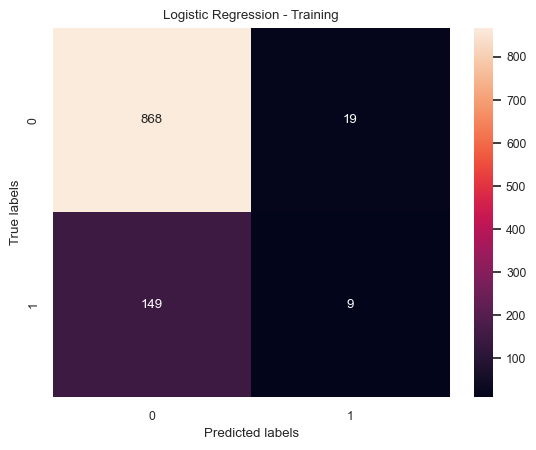

In [171]:
cm1 = confusion_matrix(y_test, log_reg.predict(X_test))
ax= plt.subplot()
sns.heatmap(cm1,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression - Training');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);


447 people are false negative = not so good

Confusion matrix WITH SMOTE

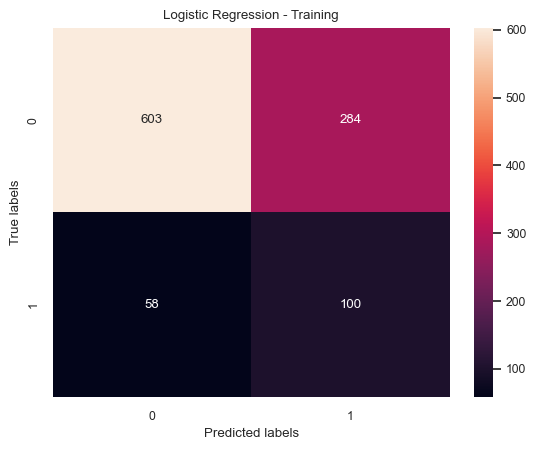

In [172]:
cm2 = confusion_matrix(y_test,log_reg_sm.predict(X_test))
ax= plt.subplot()
sns.heatmap(cm2,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression - Training');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

ROC WITHOUT SMOTE

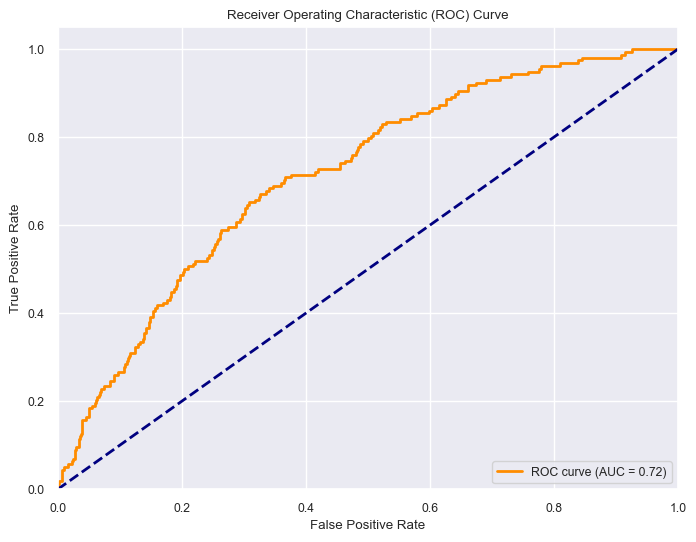

In [173]:
# Step 1: Compute the predicted probabilities for the positive class
y_prob = log_reg.predict_proba(X_test)[:,1]

# Step 2: Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Step 3: Compute the AUC
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

This ROC value indicates a poor performance - there is a 72% chance that the model will be able to distinguish between positive class and negative class

ROC WITH SMOTE

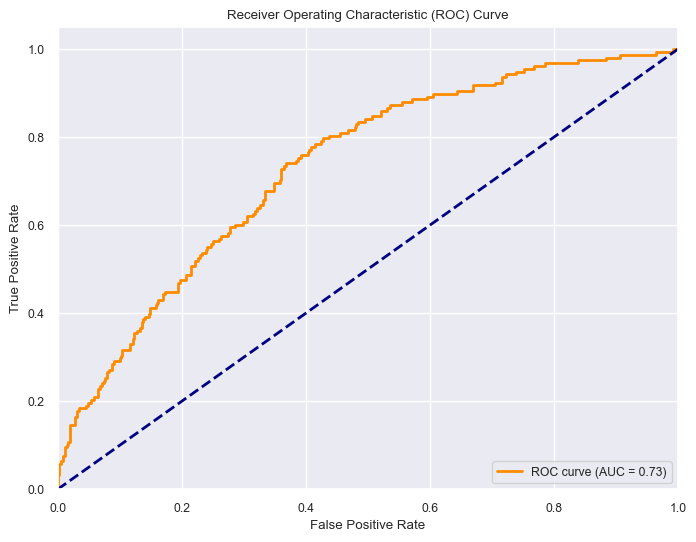

In [174]:
# Step 1: Compute the predicted probabilities for the positive class
y_prob_sm = log_reg_sm.predict_proba(X_test)[:,1]

# Step 2: Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_sm)

# Step 3: Compute the AUC
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Random Forest

WITHOUT SMOTE

In [200]:
param_grid = {
    'n_estimators': [200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [201]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}


In [202]:
rf_y_pred = best_rf.predict(X_test)
print("Accuracy on training set: {:.3f}".format(best_rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(best_rf.score(X_test, y_test)))

Accuracy on training set: 0.898
Accuracy on test set: 0.856


WITH SMOTE

In [203]:
param_grid = {
    'n_estimators': [200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search_sm = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_res, y_res)
best_rf_sm = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.850 total time=   0.8s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=0.853 total time=   0.7s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.852 total time=   0.7s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=0.850 total time=   0.8s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.845 total time=   0.7s
[CV 2/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.853 total time=   1.1s
[CV 4/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=0.852 total time=   1.1s
[CV

KeyboardInterrupt: 

] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=0.704 total time=   1.5s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.701 total time=   1.5s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=0.698 total time=   1.5s
[CV 5/5] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.804 total time=   2[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=0.848 total time=   0.8s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=0.844 total time=   0.7s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=0.853 total time=   0.7s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=2, mi

In [204]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [205]:
rf_sm_y_pred = best_rf_sm.predict(X_test)
print("Accuracy on training set: {:.3f}".format(rf.score(X_res, y_res)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

NameError: name 'best_rf_sm' is not defined

Classification report WITHOUT SMOTE

In [198]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       887
           1       0.65      0.07      0.13       158

    accuracy                           0.85      1045
   macro avg       0.75      0.53      0.52      1045
weighted avg       0.83      0.85      0.80      1045



Classifciation report WITH SMOTE

In [180]:
print(classification_report(y_test, rf_sm_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       887
           1       0.29      0.42      0.34       158

    accuracy                           0.75      1045
   macro avg       0.59      0.62      0.59      1045
weighted avg       0.80      0.75      0.77      1045



Confusion metrix WITHOUT SMOTE

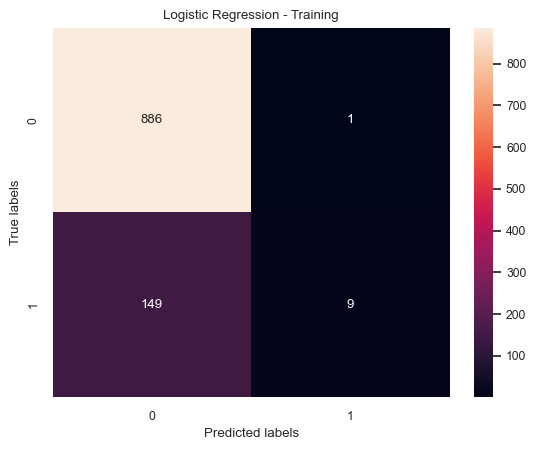

In [181]:
cm3 = confusion_matrix(y_test,rf.predict(X_test))
ax= plt.subplot()
sns.heatmap(cm3,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression - Training');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

Confusion metrix WITH SMOTE

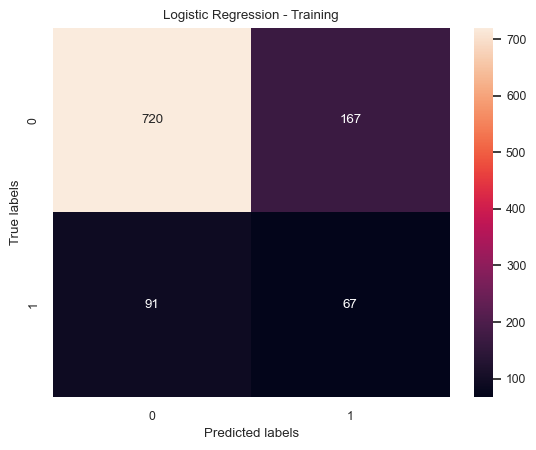

In [182]:
cm4 = confusion_matrix(y_test,rf_sm.predict(X_test))
ax= plt.subplot()
sns.heatmap(cm4,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression - Training');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

ROC WITHOUT SMOTE

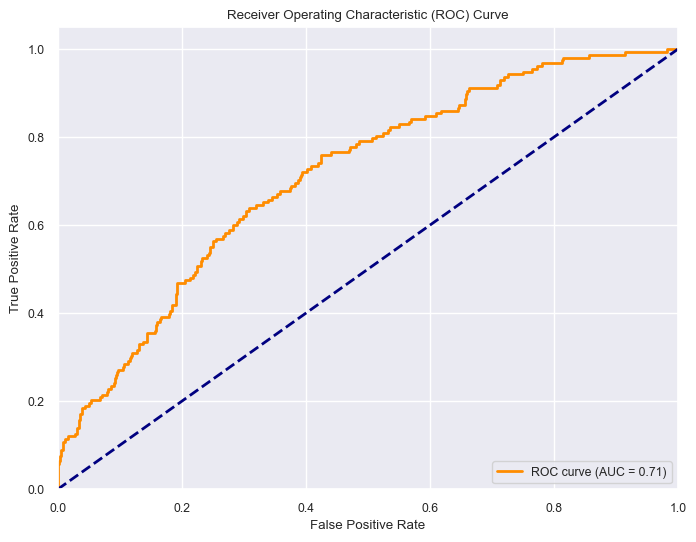

In [183]:
# Step 1: Compute the predicted probabilities for the positive class
y_prob2 = rf.predict_proba(X_test)[:,1]

# Step 2: Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob2)

# Step 3: Compute the AUC
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ROC WITH SMOTE

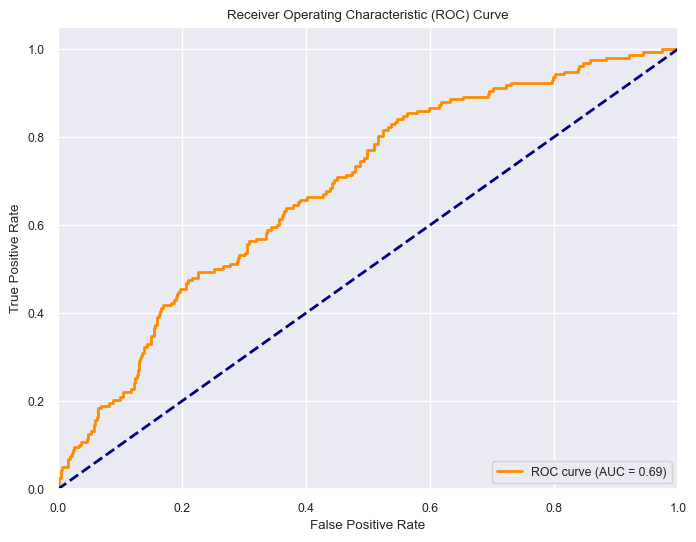

In [184]:
# Step 1: Compute the predicted probabilities for the positive class
y_prob_sm2 = rf_sm.predict_proba(X_test)[:,1]

# Step 2: Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_sm2)

# Step 3: Compute the AUC
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# KNN

# Decision Tree Classifier 

In [185]:
columns = ['sysBP', 'glucose', 'age', 'totChol', 'cigsPerDay', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'gender', 'prevalentStroke', 'BMI', 'heartRate', 'currentSmoker']
X = chd_df[columns]
X
y = chd_df["CHD"]
y

decisionTree = tree.DecisionTreeClassifier() 
decisionTree.fit(X, y)
print("Accuracy on trained data set - gotta change this: {:.3f}".format(decisionTree.score(X, y)))



KeyError: "['BMI', 'heartRate', 'currentSmoker'] not in index"

In [ ]:
decisionTree = tree.DecisionTreeClassifier(max_depth=5) 
decisionTree.fit(X, y)
print("Accuracy on training set: {:.3f}".format(decisionTree.score(X, y)))